# Fig 2C-I : Drug response prediction from cell lines to PDX.
This notebooks support Fig2 panel C to I and corresponds to the PDX prediction based on cell lines drug response.

In [128]:
import os, sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
import scipy
from copy import deepcopy
import uuid
from pickle import load, dump
import re
from datetime import date
sns.set_style("whitegrid")
sns.set_context('paper')
from matplotlib import font_manager as fm, rcParams
fpath = os.path.join(rcParams["datapath"], "fonts/ttf/arial.ttf")
prop_label = fm.FontProperties(fname=fpath)
prop_label.set_size(30)
prop_ticks = fm.FontProperties(fname=fpath)
prop_ticks.set_size(25)
fname = os.path.split(fpath)[1]

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle, resample
from joblib import dump, load, Parallel, delayed
from statannot.statannot import add_stat_annotation
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from skorch import NeuralNetClassifier, NeuralNetRegressor

sys.path.insert(0, '../read_data/')
from read_data import read_data
from read_GDSC_response import read_GDSC_response
from read_PDXE_response import read_PDXE_response
from reformat_df import reformat_df
import library_size_normalization

sys.path.insert(0, '../src/')
from clf_utils import make_network

from precise.pv_computation import PVComputation
from precise.interpolation import Interpolation
from precise.matrix_operations import _center_kernel, _right_center_kernel, _left_center_kernel
from precise.kernel_computer import KernelComputer
from precise.PRECISE import PRECISE

from compute_proportion import compute_proportion

In [129]:
# Normalization
with_mean = True
with_std = True

# domain adaptation
tissues = {
    'PDXE': ['All'],
    'GDSC': ['All']
}
projects = {
    'PDXE':[None],
    'GDSC': None
}

data_sources = ['GDSC', 'PDXE']

data_types = ['fpkm']
genes_filtering = 'mini'
data_normalization = 'library_size' # Can be TPM, "library_size" or "log". Else will not have any influence.

source = 'GDSC'
target = 'PDXE'

output_combat_cv_folder = '/DATA/s.mourragui/output/kernel_PRECISE/GDSC_PDXE/neural_network_combat/'
output_uncorrected_cv_folder = '/DATA/s.mourragui/output/kernel_PRECISE/GDSC_only/neural_network/'

random_state = 183627362

## Read data

In [130]:
data_df = read_data(tissues=tissues,
                    data_types=[e for e in data_types],
                    projects=projects,
                    data_sources=data_sources,
                    folder_basis='../data/')

source_data_key, target_data_key = reformat_df(data_df, source, target)

data_df_combat = deepcopy(data_df)

DATA UPLOADED
GENE HARMONIZED ACROSS VIEWS
CHECKED FOR GOOD HARMONIZATION


In [131]:
# Library size normalization
average_depth_global = 10**5
for ds in list(data_df.keys()):
    GE_normalized = library_size_normalization.TMM_normalization(data_df[ds].values.astype(float))
    GE_normalized = np.array(GE_normalized)
    average_depths = np.mean(np.sum(GE_normalized,1))
    data_df_combat[ds] = pd.DataFrame(np.log(np.array(GE_normalized)+1),
                                     columns=data_df_combat[ds].columns,
                                     index=data_df_combat[ds].index)
    GE_normalized = GE_normalized / average_depths * average_depth_global
    GE_normalized = np.log(np.array(GE_normalized)+1)
    data_df[ds] = pd.DataFrame(GE_normalized,
                               columns=data_df[ds].columns,
                               index=data_df[ds].index)

In [132]:
# Reducing genes for ComBat
number_top_genes = 1700

top_source_variable_genes = pd.DataFrame(np.var(data_df[source_data_key]), columns=['variance'])
top_source_variable_genes = top_source_variable_genes.sort_values('variance', ascending=False)
top_source_variable_genes = top_source_variable_genes.head(number_top_genes).index
top_target_variable_genes = pd.DataFrame(np.var(data_df[target_data_key]), columns=['variance'])
top_target_variable_genes = top_target_variable_genes.sort_values('variance', ascending=False)
top_target_variable_genes = top_target_variable_genes.head(number_top_genes).index
top_variable_genes = np.intersect1d(top_source_variable_genes, top_target_variable_genes)
print(top_variable_genes.shape)

for d in data_df:
    data_df_combat[d] = data_df_combat[d][top_variable_genes]

(1666,)


In [133]:
normalized_data_df = {
    ds : StandardScaler(with_mean=with_mean, with_std=with_std).fit_transform(data_df[ds])
    for ds in data_df
}

for ds in normalized_data_df:
    normalized_data_df[ds] = pd.DataFrame(normalized_data_df[ds],
                                         index=data_df[ds].index,
                                         columns=data_df[ds].columns)

### Drug response

In [134]:
# GDSC
unique_drugs = None
GDSC_drug_response_frames = {}
for x in ['GDSC2', 'GDSC1']:
    GDSC_drug_response_file = '../data/GDSC/response/%s_fitted_dose_response_25Feb20.xlsx'%(x)
    GDSC_drug_response_frames[x] = pd.read_excel(GDSC_drug_response_file)
    if unique_drugs is None:
        unique_drugs = np.unique(GDSC_drug_response_frames[x]['DRUG_NAME'])
    else:
        unique_drugs = np.concatenate([unique_drugs, np.unique(GDSC_drug_response_frames[x]['DRUG_NAME'])])

In [135]:
# PDX
PDX_drug_response_df = pd.read_csv('../data/PDXE/response/response.csv', index_col=0)

## Alignment settings
### Different similarity functions to test

In [137]:
kernel_surnames = ['linear_centered_standardized',
                   'rbf_gamma_1_centered_standardized',
                   'rbf_gamma_2_centered_standardized',
                   'rbf_gamma_3_centered_standardized',
                   'rbf_gamma_4_centered_standardized',
                   'rbf_gamma_5_centered_standardized',
                   'rbf_gamma_6_centered_standardized',
                   'rbf_gamma_7_centered_standardized'
                  ]

order = [
    'uncorrected_EN',
    'uncorrected_network',
    'combat_network',
    'linear_centered_standardized',
    'rbf_gamma_1_centered_standardized',
    'rbf_gamma_2_centered_standardized',
    'rbf_gamma_3_centered_standardized',
    'rbf_gamma_4_centered_standardized',
    'rbf_gamma_5_centered_standardized',
    'rbf_gamma_6_centered_standardized',
    'rbf_gamma_7_centered_standardized'
]
labels = [
    'Elastic Net',
    'DL',
    'ComBat + DL',
    'PRECISE',
    r'$\gamma$=1$\times$$10^{-5}$',
    r'$\gamma$=3$\times$$10^{-5}$',
    r'$\gamma$=1$\times$$10^{-4}$',
    r'$\gamma$=3$\times$$10^{-4}$',
    r'$\gamma$=1$\times$$10^{-3}$',
    r'$\gamma$=3$\times$$10^{-3}$',
    r'$\gamma$=1$\times$$10^{-2}$',
]


kernel_names = ['linear', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf']
kernel_param = [
    {},
    {'gamma': 10**(-5)},
    {'gamma': 10**(-4.5)},
    {'gamma': 10**(-4)},
    {'gamma': 10**(-3.5)},
    {'gamma': 10**(-3)},
    {'gamma': 10**(-2.5)},
    {'gamma': 10**(-2)}
]


kernel_param = {k:p for k,p in zip(kernel_surnames, kernel_param)}

number_pc = {
    'source': 70,
    'target': 50
}

n_pv = [20, 20, 20, 20, 20, 20, 20, 20]
n_pv = {k:p for k,p in zip(kernel_surnames, n_pv)}
n_interpolation = 100

### Load drug data

In [201]:
# Potential pairs:
#     ('Erlotinib', 'erlotinib'),
#     ('Cetuximab', 'cetuximab'),
#     ('Gemcitabine', 'gemcitabine-50mpk'),
#     ('Afatinib', 'trastuzumab'),
#     ('Paclitaxel', 'paclitaxel'),
#     ('Trametinib', 'trametinib'),
#     ('Ruxolitinib', 'INC424'),
GDSC_drug_name, PDXE_drug_name = ('Ruxolitinib', 'INC424')

drug_folder_name = 'response_GDSC_%s_PDXE_%s'%(GDSC_drug_name, PDXE_drug_name)
if drug_folder_name not in os.listdir('./figures/'):
    os.mkdir('./figures/'+drug_folder_name)
drug_folder_name = './figures/'+drug_folder_name


X_target_response, y_target = read_PDXE_response(PDX_drug_response_df,
                                                 PDXE_drug_name,
                                                 normalized_data_df[target_data_key])
X_source_response, y_source = read_GDSC_response(GDSC_drug_response_frames,
                                                 GDSC_drug_name,
                                                 normalized_data_df[source_data_key])

X_target_response_combat, y_target_combat = read_PDXE_response(PDX_drug_response_df,
                                                               PDXE_drug_name,
                                                               data_df_combat[target_data_key])
X_source_response_combat, y_source_combat = read_GDSC_response(GDSC_drug_response_frames,
                                                               GDSC_drug_name,
                                                               data_df_combat[source_data_key])

combat_cv_folder = output_combat_cv_folder + GDSC_drug_name
uncorrected_cv_folder = GDSC_drug_name + ('_centered' if with_mean else '') + ('_standardized' if with_std else '')
uncorrected_cv_folder = output_uncorrected_cv_folder + uncorrected_cv_folder

(198,)
(198,)


## Test for various values of similarities and baselines
### Import CV deep network architecture

In [202]:
param_names = ['hidden', 'input', 'activation', 'hiddenDO', 'inputDO', 'l2pen', 'lr']
def parse_folder_results(f, folder):
    param = {}
    for n in param_names:
        param[n] = re.search('%s_([0-9A-Za-z-.]+)'%(n), f)
        param[n] = [param[n].group(1)] if param[n] else ''
    param['folder'] = f
    param_df = pd.DataFrame.from_dict(param)
    
    results_files = ['%s/%s/'%(folder, f) + e for e in os.listdir('%s/%s'%(folder, f))
                     if '.csv' in e and 'pred_perf' in e and (str(random_state) in e or random_state is None)]
    
    if len(results_files) == 0:
        return None
    
    results_df = [pd.read_csv(r, header=0, index_col=0) for r in results_files]
    results_df = pd.concat(results_df)
    results_df.index = [f] * results_df.shape[0]
        
    return results_df

def read_best_param(folder, output_fig=None):
    relevant_subfolders = [e for e in os.listdir(folder)
                           if 'hidden' in e]

    results_df = [parse_folder_results(f, folder)
                              for f in relevant_subfolders]
    results_df = [df for df in results_df if df is not None]
    results_df = pd.concat(results_df)

    baseline_df = pd.read_csv('%s/baseline_pred_perf_random-state_%s.csv'%(folder,
                                                                           random_state),
                              header=0, index_col=0)

    results_df.columns = [('model', e) for e in results_df.columns]
    for e in ['MSE', 'pred_perf']:
        results_df[('baseline', e)] = baseline_df[e].values[0]
    results_df.columns = pd.MultiIndex.from_tuples(results_df.columns)

    if output_fig is not None:
        results_df.to_csv('%s/%s'%(drug_folder_name, output_fig))
    
    best_model = results_df.sort_values(('model', 'pred_perf'), ascending=False).index[0]
    best_model_param = folder + '/' + best_model + '/param.pkl'
    best_model_param = load(open(best_model_param, 'rb'))
    return best_model_param

def make_skorch_network(net, param):
    return NeuralNetRegressor(
        net,
        max_epochs=param['n_epochs'],
        lr=param['learning_rate'],
        batch_size=param['batch_size'],
        device= 'cuda' if torch.cuda.is_available() else 'cpu',
        optimizer=torch.optim.SGD,
        optimizer__momentum=param['momentum'],
        optimizer__weight_decay=param['l2_penalty'],
        iterator_train__shuffle = True,
        verbose=0
    )

In [203]:
uncorrected_param = read_best_param(uncorrected_cv_folder, 'uncorrected_cv_results.csv')
combat_param = read_best_param(combat_cv_folder, 'combat_cv_results.csv')

combat_param['n_input'] = data_df_combat[source_data_key].shape[1]
uncorrected_param['n_input'] = data_df[source_data_key].shape[1]

In [191]:
uncorrected_network = make_network(uncorrected_param)
uncorrected_network = Pipeline([
    ('scaler', StandardScaler(with_mean=with_mean, with_std=with_std)),
    ('regression', make_skorch_network(uncorrected_network, uncorrected_param))
])

combat_network = make_network(combat_param)
combat_network = make_skorch_network(combat_network, combat_param)

In [14]:
def predict_PDX_spearman_cor(n_jobs=20, verbose=0, return_clf=False):
    target_spearman = {}
    
    if return_clf:
        classifiers = {}
        
    for sim_surname, sim_name in zip(kernel_surnames, kernel_names):
        #For each kernel:
        #    - compute consensus features and project bootstrapped data on them,
        #    - train predictive model based on bootstrapped labels,
        #    - predict on target and save spearman correlation.
        print(sim_surname)
        clf = PRECISE(kernel=sim_name,
                      kernel_params=kernel_param[sim_surname],
                      n_components=number_pc,
                      n_jobs=n_jobs,
                      verbose=verbose)
        
        clf.fit(normalized_data_df[source_data_key],
                normalized_data_df[target_data_key],
                n_pv=n_pv[sim_surname],
                step=n_interpolation,
                with_interpolation=True)

        clf.fit_predictor(X_source_response, y_source.values.flatten(), l1_ratio=0.)
        y_target_subsample_predicted = clf.predict(X_target_response)
        target_spearman[sim_surname] = scipy.stats.spearmanr(y_target_subsample_predicted,
                                                             y_target['BestAvgResponse'])
        if return_clf:
            classifiers[sim_surname] = deepcopy(clf)
        
    # Comparison to baseline
    print('raw')
    alpha_values = np.logspace(-5,10,16)
    l1_ratio_values = np.linspace(1,10,11)/10
    param_grid ={
        'regression__alpha': alpha_values,
        'regression__l1_ratio': l1_ratio_values
    }
    grid_raw = GridSearchCV(Pipeline([
                            ('scaler', StandardScaler(with_mean=with_mean, with_std=with_std)),
                            ('regression', ElasticNet())
                            ]),
                            cv=10, 
                            n_jobs=n_jobs, 
                            param_grid=param_grid, 
                            verbose=verbose, 
                            scoring='neg_mean_squared_error')
    grid_raw.fit(X_source_response, y_source.values.flatten())
    y_target_subsample_predicted = grid_raw.predict(X_target_response)
    target_spearman['uncorrected_EN'] = scipy.stats.spearmanr(y_target_subsample_predicted,
                                                        y_target['BestAvgResponse'])
    classifiers['raw'] = grid_raw
    
    # Neural network without correction
    print('Neural network uncorrected')
    uncorrected_network.fit(X_source_response.values.astype(np.float32), y_source.values.astype(np.float32))
    y_target_subsample_predicted = uncorrected_network.predict(X_target_response.values.astype(np.float32)).flatten()
    target_spearman['uncorrected_network'] = scipy.stats.spearmanr(y_target_subsample_predicted,
                                                                   y_target['BestAvgResponse'].values.flatten())
    classifiers['uncorrected_network'] = uncorrected_network
    
    # Neural network without correction
    print('Neural network with ComBat')
    combat_network.fit(X_source_response_combat.values.astype(np.float32),
                       y_source_combat.values.astype(np.float32))
    y_target_subsample_predicted = combat_network.predict(X_target_response_combat.values.astype(np.float32)).flatten()
    target_spearman['combat_network'] = scipy.stats.spearmanr(y_target_subsample_predicted,
                                                                   y_target['BestAvgResponse'].values.flatten())
    classifiers['combat_network'] = combat_network
    
    if return_clf:
        return target_spearman, classifiers
    return target_spearman

In [15]:
n_jobs=30

correlations_per_sim, clfs = predict_PDX_spearman_cor(n_jobs=n_jobs, verbose=0, return_clf=True)
saving_id = str(uuid.uuid4())[:8]
dump(correlations_per_sim, '%s/prediction_%s.csv'%(drug_folder_name,
                                                   saving_id))

linear_centered_standardized
rbf_gamma_1_centered_standardized
rbf_gamma_2_centered_standardized
rbf_gamma_3_centered_standardized
rbf_gamma_4_centered_standardized
rbf_gamma_5_centered_standardized
rbf_gamma_6_centered_standardized
rbf_gamma_7_centered_standardized
raw
Neural network uncorrected
Neural network with ComBat


['./figures/response_GDSC_Afatinib_PDXE_trastuzumab/prediction_3111b2af.csv']

In [204]:
potential_file = os.listdir(drug_folder_name)
potential_file = [p for p in potential_file if 'prediction' in p]
if len(potential_file) == 1:
    file = potential_file[0]
else:
    print('MORE THAN ONE FILE')
    print(potential_file)

MORE THAN ONE FILE
['prediction_122e8b39.csv', 'prediction_ea38c8cc.csv']


In [205]:
file = 'prediction_122e8b39.csv'
saving_id = re.search(r'_([0-9a-z]*).csv', file).group(1)
correlations_per_sim = load(open(drug_folder_name + '/' + file, 'rb'))
del file

## Plot results

In [206]:
to_plot_df = pd.DataFrame(correlations_per_sim)
to_plot_df = to_plot_df.T
to_plot_df.columns = ['cor', 'p-val']
to_plot_df = to_plot_df.loc[order]
to_plot_df.index = labels

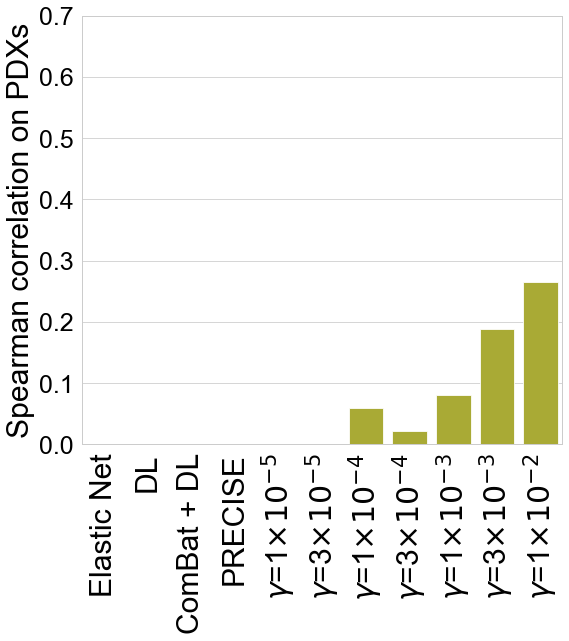

In [207]:
yticks = np.arange(0,8) / 10
yticks_labels = [str(y) for y in yticks]
colors = [mpl.colors.TABLEAU_COLORS['tab:gray']] * 4 + \
          [mpl.colors.TABLEAU_COLORS['tab:olive']] * 20

plt.figure(figsize=(8,9))
bplot = sns.barplot(data=to_plot_df.reset_index(),
                    x='index',
                    y='cor',
                    order=labels,
                    palette=colors, alpha=1.)

plt.xlabel(None)
plt.xticks(fontsize=25, color='black', rotation=90, fontproperties=prop_label)
plt.ylim(0,0.7)
plt.yticks(yticks, yticks_labels, fontsize=25, fontproperties=prop_ticks, color='black')
plt.ylabel('Spearman correlation on PDXs', fontsize=25, color='black', fontproperties=prop_label)
plt.tight_layout()
plt.savefig('%s/results_%s.png'%(drug_folder_name, saving_id), dpi=300)